<h1 align=center><font size = 5>Berlin Airbnb Price Analysis </font></h1>

## Introduction

In this project I have scraped data from various data about Berlin Airbnb prices per night and its Boroughs.Then I used Foursquare API to get the common venues of the boroughs.Then using K-means clustering I clustered Berlin Neighborhoods on the basis of the common venues.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import requests
import json
%matplotlib inline

## Importing Dataset

These dataset can be downloaded from the data.insideairbnb.com webpage. For this project we are getting the listing of every room offered in the city with its price per night in euros. 

In [2]:
url1='http://data.insideairbnb.com/germany/be/berlin/2019-09-19/visualisations/listings.csv'
df_berlin=pd.read_csv(url1, delimiter=',')
df_berlin

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1944,cafeheaven Pberg/Mitte/Wed for the summer 2019,2164,Lulah,Mitte,Brunnenstr. Nord,52.54425,13.39749,Private room,21,120,18,2018-11-11,0.25,1,364
1,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ion,Mitte,Brunnenstr. Süd,52.53454,13.40256,Entire home/apt,60,4,127,2019-09-05,3.03,5,170
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.53500,13.41758,Entire home/apt,90,62,145,2019-06-27,1.16,1,349
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.49885,13.34906,Private room,28,7,27,2019-05-31,0.36,1,262
4,6883,Stylish East Side Loft in Center with AC & 2 b...,16149,Steffen,Friedrichshain-Kreuzberg,Frankfurter Allee Süd FK,52.51171,13.45477,Entire home/apt,125,3,126,2019-09-08,1.08,1,7
5,7071,BrightRoom with sunny greenview!,17391,BrightRoom,Pankow,Helmholtzplatz,52.54316,13.41509,Private room,33,2,253,2019-09-06,2.06,2,33
6,9991,Geourgeous flat - outstanding views,33852,Philipp,Pankow,Prenzlauer Berg Südwest,52.53303,13.41605,Entire home/apt,180,6,7,2019-07-15,0.14,1,37
7,14325,Apartment in Prenzlauer Berg,55531,Chris + Oliver,Pankow,Prenzlauer Berg Nordwest,52.54785,13.40556,Entire home/apt,70,90,24,2019-07-01,0.21,4,308
8,16401,APARTMENT TO RENT,59666,Melanie,Friedrichshain-Kreuzberg,Frankfurter Allee Süd FK,52.51051,13.45785,Private room,120,30,0,NaN,NaN,1,365
9,16644,In the Heart of Berlin - Kreuzberg,64696,Rene,Friedrichshain-Kreuzberg,nördliche Luisenstadt,52.50479,13.43510,Entire home/apt,90,60,48,2017-12-14,0.42,2,31


## Cleaning the Data Frame

Berlin is divided in 12 big neighbourhoods or boroughs shown as neighbourhood group. For this analysis we are working with this column. The neighbourhood column gives more information about an specific place or street of the city and it is not necessarily a neighbourhood.  

First, adjust the name of the neighbourhood 'Charlottenburg-Wilmersdorf'

In [3]:
df_berlin.loc[df_berlin['neighbourhood_group']=='Charlottenburg-Wilm.','neighbourhood_group']='Charlottenburg-Wilmersdorf'

Drop the unnecessary columns from the data frame.

In [4]:
df_berlin.drop(['id','name','host_id','host_name','neighbourhood','minimum_nights','number_of_reviews','last_review','reviews_per_month','calculated_host_listings_count','availability_365','room_type'],axis=1, inplace=True)

Rename the name of the column. 

In [5]:
df_berlin=df_berlin.rename(columns={'neighbourhood_group':'Neighbourhood'})
df_berlin

,Neighbourhood,latitude,longitude,price
0,Mitte,52.54425,13.39749,21
1,Mitte,52.53454,13.40256,60
2,Pankow,52.53500,13.41758,90
3,Tempelhof - Schöneberg,52.49885,13.34906,28
4,Friedrichshain-Kreuzberg,52.51171,13.45477,125
5,Pankow,52.54316,13.41509,33
6,Pankow,52.53303,13.41605,180
7,Pankow,52.54785,13.40556,70
8,Friedrichshain-Kreuzberg,52.51051,13.45785,120
9,Friedrichshain-Kreuzberg,52.50479,13.43510,90


Check that data frame has no missing values

In [6]:
df_berlin.isna().sum()

Neighbourhood    0
latitude         0
longitude        0
price            0
dtype: int64

Check the size of the data frame

In [7]:
df_berlin.shape

(24422, 4)

Check the columns type in the Data Frame. Here we see that the price per night is an intenger.

In [8]:
df_berlin.dtypes

Neighbourhood     object
latitude         float64
longitude        float64
price              int64
dtype: object

Then, it is adjusted to a float type.

In [9]:
df_berlin=df_berlin.astype({'Neighbourhood':str,'latitude':float,'longitude':float,'price':float})

The columns types are as expected for our analysis.

In [10]:
df_berlin.dtypes

Neighbourhood     object
latitude         float64
longitude        float64
price            float64
dtype: object

### Finding Longitude and Latitude of the neighbourhoods

For our mapping we are dropping the price column for now and grouping the data frame according these  12 neighbourhoods. We used the mean operation so we get the central coordinates for each zone of the city. 

In [11]:
df_berlin1=df_berlin.drop(['price'],axis=1)
df_berlin1=df_berlin1.groupby(['Neighbourhood']).mean()
df_berlin1=df_berlin1.reset_index()
print(df_berlin1.shape)
df_berlin1


(12, 3)


,Neighbourhood,latitude,longitude
0,Charlottenburg-Wilmersdorf,52.502948,13.306285
1,Friedrichshain-Kreuzberg,52.504415,13.434268
2,Lichtenberg,52.510492,13.494922
3,Marzahn - Hellersdorf,52.519464,13.573520
4,Mitte,52.532763,13.377393
5,Neukölln,52.477541,13.435818
6,Pankow,52.545903,13.421873
7,Reinickendorf,52.582653,13.325859
8,Spandau,52.528167,13.189566
9,Steglitz - Zehlendorf,52.442613,13.292098


Then, we use geolocator to get the central coordinates of the city in order to plot the map.

In [12]:
address = 'Berlin,DE'
geolocator = Nominatim(user_agent="Berlin")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


### Create a Berlin map with neighborhoods

In [13]:
# create map of Toronto using latitude and longitude values
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_berlin1['latitude'],df_berlin1['longitude'], df_berlin1['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

Next, we use the Foursquare API to explore the neighborhoods and segment them.

### Define Foursquare Credentials and Version

In [14]:
CLIENT_ID = 'PIFV5AJ0MCCH41C1NLQ4SQ4DQRRUGAZPXDKLIUMNBOALHD3Z' # your Foursquare ID
CLIENT_SECRET = '4JEW3OEWYWNGHURNMIZUPARSJLDG4F4M3DVF24TYV1HCNOGG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

We set a limit of 100 locations in a radius of 4.5 Km because of the size of the neighbourhoods.

In [15]:
LIMIT=100
RADIUS=4500

### Explore the locations

Using the Foursquare API, we make a function to get the corresponding json file giving us the information from every location we are asking for. The jason file is cleaned and turned into a data frame afterwards.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

        


Then, we run our function for all Location in the dataframe

In [17]:
berlin_venues = getNearbyVenues(names=df_berlin1['Neighbourhood'],
                                   latitudes=df_berlin1['latitude'],
                                   longitudes=df_berlin1['longitude']
                                  )

Charlottenburg-Wilmersdorf
Friedrichshain-Kreuzberg
Lichtenberg
Marzahn - Hellersdorf
Mitte
Neukölln
Pankow
Reinickendorf
Spandau
Steglitz - Zehlendorf
Tempelhof - Schöneberg
Treptow - Köpenick


Let's see our new data frame and check its size.

In [18]:
print(berlin_venues.shape)
berlin_venues.head()

(398, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Charlottenburg-Wilmersdorf,52.502948,13.306285,Goldhahn & Sampson,52.503891,13.307557,Gourmet Shop
1,Charlottenburg-Wilmersdorf,52.502948,13.306285,Saigon Today,52.504471,13.307391,Vietnamese Restaurant
2,Charlottenburg-Wilmersdorf,52.502948,13.306285,Alnatura,52.502257,13.309253,Organic Grocery
3,Charlottenburg-Wilmersdorf,52.502948,13.306285,Impala Coffee,52.504799,13.307089,Coffee Shop
4,Charlottenburg-Wilmersdorf,52.502948,13.306285,Frau Behrens Torten,52.501653,13.307663,Café


Let's check the number of locations for each neighbourhood

In [19]:
berlin_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Charlottenburg-Wilmersdorf,100,100,100,100,100,100
Friedrichshain-Kreuzberg,40,40,40,40,40,40
Lichtenberg,27,27,27,27,27,27
Marzahn - Hellersdorf,4,4,4,4,4,4
Mitte,42,42,42,42,42,42
Neukölln,32,32,32,32,32,32
Pankow,87,87,87,87,87,87
Reinickendorf,2,2,2,2,2,2
Spandau,9,9,9,9,9,9


Let's check how many different kinds of venues are in our data frame.

In [20]:
print('There are {} uniques categories.'.format(len(berlin_venues['Venue Category'].unique())))

There are 130 uniques categories.


### Analyzing each Neighborhood Location

In [21]:
# one hot encoding
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
berlin_onehot['Neighbourhood'] = berlin_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

berlin_onehot.head()

,Neighbourhood,ATM,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,...,Theater,Trail,Tram Station,Trattoria/Osteria,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery,Yoga Studio
0,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
berlin_onehot.shape

(398, 131)

### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [23]:
berlin_grouped =berlin_onehot.groupby('Neighbourhood').mean().reset_index()
berlin_grouped

,Neighbourhood,ATM,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,...,Theater,Trail,Tram Station,Trattoria/Osteria,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery,Yoga Studio
0,Charlottenburg-Wilmersdorf,0.000000,0.01,0.00,0.000000,0.000000,0.000,0.000,0.000000,0.01,...,0.00,0.00,0.00000,0.000000,0.00000,0.010000,0.040000,0.000000,0.000000,0.000000
1,Friedrichshain-Kreuzberg,0.000000,0.00,0.00,0.000000,0.000000,0.025,0.025,0.000000,0.00,...,0.00,0.00,0.00000,0.025000,0.00000,0.000000,0.000000,0.025000,0.000000,0.000000
2,Lichtenberg,0.037037,0.00,0.00,0.000000,0.037037,0.000,0.000,0.000000,0.00,...,0.00,0.00,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Marzahn - Hellersdorf,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.000,0.000000,0.00,...,0.00,0.25,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Mitte,0.000000,0.00,0.00,0.000000,0.023810,0.000,0.000,0.000000,0.00,...,0.00,0.00,0.02381,0.023810,0.02381,0.023810,0.000000,0.000000,0.000000,0.000000
5,Neukölln,0.000000,0.00,0.00,0.031250,0.000000,0.000,0.000,0.000000,0.00,...,0.00,0.00,0.00000,0.000000,0.00000,0.031250,0.000000,0.000000,0.000000,0.000000
6,Pankow,0.000000,0.00,0.00,0.011494,0.011494,0.000,0.000,0.000000,0.00,...,0.00,0.00,0.00000,0.022989,0.00000,0.011494,0.022989,0.000000,0.011494,0.011494
7,Reinickendorf,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.000,0.000000,0.00,...,0.00,0.00,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Spandau,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.000,0.000000,0.00,...,0.00,0.00,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Steglitz - Zehlendorf,0.000000,0.00,0.05,0.000000,0.000000,0.000,0.000,0.000000,0.00,...,0.05,0.00,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


### Top 10 most common venues for each neighbourhood

In [24]:
num_top_venues = 10

for hood in berlin_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = berlin_grouped[berlin_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Charlottenburg-Wilmersdorf----
                   venue  freq
0                  Hotel  0.08
1     Italian Restaurant  0.08
2                   Café  0.07
3  Vietnamese Restaurant  0.04
4            Supermarket  0.03
5           Burger Joint  0.03
6    Japanese Restaurant  0.03
7                    Bar  0.03
8             Steakhouse  0.03
9                 Bakery  0.03


----Friedrichshain-Kreuzberg----
                   venue  freq
0                  Hotel  0.10
1      German Restaurant  0.08
2                    Bar  0.08
3              Nightclub  0.05
4             Restaurant  0.05
5     Italian Restaurant  0.05
6         Ice Cream Shop  0.05
7   Caribbean Restaurant  0.02
8   Cantonese Restaurant  0.02
9  Street Food Gathering  0.02


----Lichtenberg----
               venue  freq
0             Bakery  0.19
1        Supermarket  0.11
2        Coffee Shop  0.07
3        Pizza Place  0.07
4           Bus Stop  0.07
5                ATM  0.04
6           Platform  0.04
7  Conveni

### Put in the Dataframe

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create the new dataframe and display the top 10 venues for each neighborhood

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = berlin_grouped['Neighbourhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(12)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg-Wilmersdorf,Hotel,Italian Restaurant,Café,Vietnamese Restaurant,Thai Restaurant,Bakery,Steakhouse,Burger Joint,Supermarket,Japanese Restaurant
1,Friedrichshain-Kreuzberg,Hotel,Bar,German Restaurant,Ice Cream Shop,Restaurant,Italian Restaurant,Nightclub,Event Space,Caribbean Restaurant,Public Art
2,Lichtenberg,Bakery,Supermarket,Pizza Place,Bus Stop,Coffee Shop,German Restaurant,Platform,Convenience Store,Doner Restaurant,Drugstore
3,Marzahn - Hellersdorf,Soccer Field,Stadium,Gym,Trail,Doner Restaurant,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Drugstore
4,Mitte,Coffee Shop,Hotel,Restaurant,Italian Restaurant,Bakery,Café,Trattoria/Osteria,Tram Station,Burger Joint,Drugstore
5,Neukölln,Café,Middle Eastern Restaurant,Coffee Shop,Cocktail Bar,Supermarket,Park,Brewery,Breakfast Spot,Scenic Lookout,Pool
6,Pankow,Café,Bar,Falafel Restaurant,Italian Restaurant,Bakery,Playground,Cocktail Bar,Candy Store,German Restaurant,Japanese Restaurant
7,Reinickendorf,Electronics Store,Supermarket,Yoga Studio,Doner Restaurant,Falafel Restaurant,Event Space,Eastern European Restaurant,Drugstore,Dive Bar,Food Court
8,Spandau,Pizza Place,Restaurant,Hardware Store,Bus Stop,Grocery Store,Café,Supermarket,Bakery,Eastern European Restaurant,Drugstore
9,Steglitz - Zehlendorf,Supermarket,Organic Grocery,Bus Stop,Ice Cream Shop,Caucasian Restaurant,Drugstore,Flower Shop,Breakfast Spot,German Restaurant,Bank


### Normalize and Add the the average price per neighbourhood in the new dataframe

In [27]:
df_berlin_price_room=df_berlin.groupby(['Neighbourhood']).mean().reset_index()
df_berlin_price_room=df_berlin_price_room.drop(['latitude','longitude'],axis=1)

v= df_berlin_price_room.iloc[:, -1]
df_berlin_price_room.iloc[:,-1] = (v - v.min()) / (v.max() - v.min())
df_berlin_price_room

,Neighbourhood,price
0,Charlottenburg-Wilmersdorf,1.000000
1,Friedrichshain-Kreuzberg,0.270447
2,Lichtenberg,0.155844
3,Marzahn - Hellersdorf,0.165005
4,Mitte,0.542675
5,Neukölln,0.015791
6,Pankow,0.359966
7,Reinickendorf,0.000000
8,Spandau,0.137241
9,Steglitz - Zehlendorf,0.207205


In [28]:
berlin_grouped['price']=df_berlin_price_room['price']
berlin_grouped

,Neighbourhood,ATM,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,...,Trail,Tram Station,Trattoria/Osteria,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery,Yoga Studio,price
0,Charlottenburg-Wilmersdorf,0.000000,0.01,0.00,0.000000,0.000000,0.000,0.000,0.000000,0.01,...,0.00,0.00000,0.000000,0.00000,0.010000,0.040000,0.000000,0.000000,0.000000,1.000000
1,Friedrichshain-Kreuzberg,0.000000,0.00,0.00,0.000000,0.000000,0.025,0.025,0.000000,0.00,...,0.00,0.00000,0.025000,0.00000,0.000000,0.000000,0.025000,0.000000,0.000000,0.270447
2,Lichtenberg,0.037037,0.00,0.00,0.000000,0.037037,0.000,0.000,0.000000,0.00,...,0.00,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.155844
3,Marzahn - Hellersdorf,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.000,0.000000,0.00,...,0.25,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.165005
4,Mitte,0.000000,0.00,0.00,0.000000,0.023810,0.000,0.000,0.000000,0.00,...,0.00,0.02381,0.023810,0.02381,0.023810,0.000000,0.000000,0.000000,0.000000,0.542675
5,Neukölln,0.000000,0.00,0.00,0.031250,0.000000,0.000,0.000,0.000000,0.00,...,0.00,0.00000,0.000000,0.00000,0.031250,0.000000,0.000000,0.000000,0.000000,0.015791
6,Pankow,0.000000,0.00,0.00,0.011494,0.011494,0.000,0.000,0.000000,0.00,...,0.00,0.00000,0.022989,0.00000,0.011494,0.022989,0.000000,0.011494,0.011494,0.359966
7,Reinickendorf,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.000,0.000000,0.00,...,0.00,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Spandau,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.000,0.000000,0.00,...,0.00,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137241
9,Steglitz - Zehlendorf,0.000000,0.00,0.05,0.000000,0.000000,0.000,0.000,0.000000,0.00,...,0.00,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.207205


### Clustering neighbourhoods

In order to choose a suitable K number of cluster. We choose it thorugh the elbow plot. There are some elbow inflections in the plot, so we are selecting a value of 4 taking into account the number of neighbourhoods we have (12).

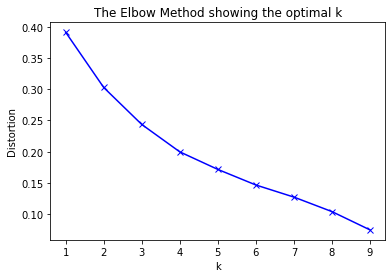

In [29]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

berlin_grouped_clustering = berlin_grouped.drop('Neighbourhood', 1)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(berlin_grouped_clustering)
    kmeanModel.fit(berlin_grouped_clustering)
    distortions.append(sum(np.min(cdist(berlin_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / berlin_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We execute ourd model using 4 clusters.

In [40]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = berlin_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 3, 1, 0, 0, 2, 0, 0])

### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [41]:
# add clustering labels

neighborhoods_venues_sorted.drop(columns = 'Cluster Labels', inplace = True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
df_berlin_final=df_berlin.groupby(['Neighbourhood']).mean().reset_index()

berlin_merged = df_berlin_final

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
berlin_merged

,Neighbourhood,latitude,longitude,price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg-Wilmersdorf,52.502948,13.306285,111.719689,1,Hotel,Italian Restaurant,Café,Vietnamese Restaurant,Thai Restaurant,Bakery,Steakhouse,Burger Joint,Supermarket,Japanese Restaurant
1,Friedrichshain-Kreuzberg,52.504415,13.434268,66.033448,0,Hotel,Bar,German Restaurant,Ice Cream Shop,Restaurant,Italian Restaurant,Nightclub,Event Space,Caribbean Restaurant,Public Art
2,Lichtenberg,52.510492,13.494922,58.856767,0,Bakery,Supermarket,Pizza Place,Bus Stop,Coffee Shop,German Restaurant,Platform,Convenience Store,Doner Restaurant,Drugstore
3,Marzahn - Hellersdorf,52.519464,13.573520,59.430464,3,Soccer Field,Stadium,Gym,Trail,Doner Restaurant,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Drugstore
4,Mitte,52.532763,13.377393,83.081012,1,Coffee Shop,Hotel,Restaurant,Italian Restaurant,Bakery,Café,Trattoria/Osteria,Tram Station,Burger Joint,Drugstore
5,Neukölln,52.477541,13.435818,50.086360,0,Café,Middle Eastern Restaurant,Coffee Shop,Cocktail Bar,Supermarket,Park,Brewery,Breakfast Spot,Scenic Lookout,Pool
6,Pankow,52.545903,13.421873,71.639370,0,Café,Bar,Falafel Restaurant,Italian Restaurant,Bakery,Playground,Cocktail Bar,Candy Store,German Restaurant,Japanese Restaurant
7,Reinickendorf,52.582653,13.325859,49.097484,2,Electronics Store,Supermarket,Yoga Studio,Doner Restaurant,Falafel Restaurant,Event Space,Eastern European Restaurant,Drugstore,Dive Bar,Food Court
8,Spandau,52.528167,13.189566,57.691824,0,Pizza Place,Restaurant,Hardware Store,Bus Stop,Grocery Store,Café,Supermarket,Bakery,Eastern European Restaurant,Drugstore
9,Steglitz - Zehlendorf,52.442613,13.292098,62.073123,0,Supermarket,Organic Grocery,Bus Stop,Ice Cream Shop,Caucasian Restaurant,Drugstore,Flower Shop,Breakfast Spot,German Restaurant,Bank


### Let's visualize the clusters

In [42]:
#berlin_merged=berlin_merged.dropna()

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['latitude'], berlin_merged['longitude'], berlin_merged['Neighbourhood'],berlin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [43]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(0, berlin_merged.shape[1]))]]

,Neighbourhood,Neighbourhood,latitude,longitude,price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Friedrichshain-Kreuzberg,Friedrichshain-Kreuzberg,52.504415,13.434268,66.033448,0,Hotel,Bar,German Restaurant,Ice Cream Shop,Restaurant,Italian Restaurant,Nightclub,Event Space,Caribbean Restaurant,Public Art
2,Lichtenberg,Lichtenberg,52.510492,13.494922,58.856767,0,Bakery,Supermarket,Pizza Place,Bus Stop,Coffee Shop,German Restaurant,Platform,Convenience Store,Doner Restaurant,Drugstore
5,Neukölln,Neukölln,52.477541,13.435818,50.086360,0,Café,Middle Eastern Restaurant,Coffee Shop,Cocktail Bar,Supermarket,Park,Brewery,Breakfast Spot,Scenic Lookout,Pool
6,Pankow,Pankow,52.545903,13.421873,71.639370,0,Café,Bar,Falafel Restaurant,Italian Restaurant,Bakery,Playground,Cocktail Bar,Candy Store,German Restaurant,Japanese Restaurant
8,Spandau,Spandau,52.528167,13.189566,57.691824,0,Pizza Place,Restaurant,Hardware Store,Bus Stop,Grocery Store,Café,Supermarket,Bakery,Eastern European Restaurant,Drugstore
9,Steglitz - Zehlendorf,Steglitz - Zehlendorf,52.442613,13.292098,62.073123,0,Supermarket,Organic Grocery,Bus Stop,Ice Cream Shop,Caucasian Restaurant,Drugstore,Flower Shop,Breakfast Spot,German Restaurant,Bank
11,Treptow - Köpenick,Treptow - Köpenick,52.459416,13.523249,59.000000,0,Café,Burger Joint,History Museum,Supermarket,Doner Restaurant,Movie Theater,Pizza Place,Laundry Service,Beach,Coffee Shop


### Cluster 2

In [44]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[0] + list(range(0, berlin_merged.shape[1]))]]

,Neighbourhood,Neighbourhood,latitude,longitude,price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg-Wilmersdorf,Charlottenburg-Wilmersdorf,52.502948,13.306285,111.719689,1,Hotel,Italian Restaurant,Café,Vietnamese Restaurant,Thai Restaurant,Bakery,Steakhouse,Burger Joint,Supermarket,Japanese Restaurant
4,Mitte,Mitte,52.532763,13.377393,83.081012,1,Coffee Shop,Hotel,Restaurant,Italian Restaurant,Bakery,Café,Trattoria/Osteria,Tram Station,Burger Joint,Drugstore
10,Tempelhof - Schöneberg,Tempelhof - Schöneberg,52.479902,13.359780,97.331701,1,Gym / Fitness Center,Bistro,Cocktail Bar,Paper / Office Supplies Store,Climbing Gym,Pool,Newsstand,Public Bathroom,Recreation Center,Restaurant


### Cluster 3

In [45]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[0] + list(range(0, berlin_merged.shape[1]))]]

,Neighbourhood,Neighbourhood,latitude,longitude,price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Reinickendorf,Reinickendorf,52.582653,13.325859,49.097484,2,Electronics Store,Supermarket,Yoga Studio,Doner Restaurant,Falafel Restaurant,Event Space,Eastern European Restaurant,Drugstore,Dive Bar,Food Court


### Cluster 4

In [46]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 3, berlin_merged.columns[[0] + list(range(0, berlin_merged.shape[1]))]]

,Neighbourhood,Neighbourhood,latitude,longitude,price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Marzahn - Hellersdorf,Marzahn - Hellersdorf,52.519464,13.57352,59.430464,3,Soccer Field,Stadium,Gym,Trail,Doner Restaurant,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Drugstore


We can see that the clusters are strongly related to the airbnb prices in the zone which depends on the location and sourroundings of the area. More central areas have the highest prices in comparison with the zones which are located in the perifery.